In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install xgboost
!pip install optuna
!pip install lightgbm
!pip install catboost

     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 47.8 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 75 kB 4.6 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 149 kB 45.7 MB/s 
     |████████████████████████████████| 112 kB 50.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=6e5376b11f8f29ca59d9e47160748c352d0352c80d7ad1325c791ca151836e3b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 76.1 MB 64 kB/s 


In [7]:
# データ操作
import numpy as np
import pandas as pd
from pandas import plotting 

# データ可視化
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#日付の扱い
import datetime
from datetime import timedelta

#正規化とか
import scipy.stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#主成分分析器
from sklearn.decomposition import PCA 

# 交差検証
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_validate

#誤差確認
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

#重回帰
from sklearn.linear_model import LinearRegression

#ランダムフォレスト
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor

#DNN
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.pipeline import Pipeline

#XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

#LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier

#CatBoost
from catboost import CatBoost
from catboost import Pool
from catboost import CatBoostClassifier

#パラメータチューニング
import optuna

#警告無視
import warnings
warnings.filterwarnings('ignore')

In [8]:
train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/18_Beginner_PCgame/train.csv")
test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SIGNATE/18_Beginner_PCgame/test.csv")

In [ ]:
train.shape

(4925, 10)

In [ ]:
train.columns

Index(['gameId', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueTotalGold',
       'blueTotalExperience', 'blueWins'],
      dtype='object')

In [ ]:
test.shape

(4925, 9)

In [ ]:
test.columns

Index(['gameId', 'blueFirstBlood', 'blueKills', 'blueDeaths', 'blueAssists',
       'blueEliteMonsters', 'blueDragons', 'blueTotalGold',
       'blueTotalExperience'],
      dtype='object')

#前処理

In [9]:
#欠損値処理のために一旦統合
#TrainFlagという列を新たに作り、訓練データにはTrue、テストデータにはFalseとしておく。
train["TrainFlag"] = True
test["TrainFlag"] = False

#訓練データとテストデータを結合する
alldata = train.append(test)

#目的変数を先頭コラムに
cols=alldata.columns.tolist()
cols=cols[-2:]+cols[:-2]

alldata =  alldata[cols] 
alldata

,blueWins,TrainFlag,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,0.0,True,0,0,7,9,8,1,1,17398,17446
1,1.0,True,1,1,8,10,8,0,0,15925,14253
2,1.0,True,2,1,14,6,15,0,0,21457,19003
3,1.0,True,3,1,6,3,4,1,1,16364,17958
4,0.0,True,4,1,3,6,3,1,1,15451,16088
...,...,...,...,...,...,...,...,...,...,...,...
4920,NaN,False,9845,1,8,6,7,2,1,18645,18720
4921,NaN,False,9846,0,3,2,3,0,0,15623,14271
4922,NaN,False,9847,1,5,3,4,0,0,15854,15917
4923,NaN,False,9848,0,6,10,6,0,0,17220,17971


In [ ]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9850 entries, 0 to 4924
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   blueWins             4925 non-null   float64
 1   TrainFlag            9850 non-null   bool   
 2   gameId               9850 non-null   int64  
 3   blueFirstBlood       9850 non-null   int64  
 4   blueKills            9850 non-null   int64  
 5   blueDeaths           9850 non-null   int64  
 6   blueAssists          9850 non-null   int64  
 7   blueEliteMonsters    9850 non-null   int64  
 8   blueDragons          9850 non-null   int64  
 9   blueTotalGold        9850 non-null   int64  
 10  blueTotalExperience  9850 non-null   int64  
dtypes: bool(1), float64(1), int64(9)
memory usage: 856.1 KB


欠損値がないことが分かった．

In [ ]:
alldata.describe()

,blueWins,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
count,4925.000000,9850.00000,9850.000000,9850.000000,9850.000000,9850.000000,9850.000000,9850.000000,9850.000000,9850.000000
mean,0.499492,4924.50000,0.501320,6.219594,5.778071,6.358579,0.523452,0.347107,17145.484873,17354.488731
std,0.500051,2843.59441,0.500024,2.876763,2.502286,3.575868,0.598088,0.476074,1404.022575,1044.965223
min,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,13919.000000,13939.000000
25%,0.000000,2462.25000,0.000000,4.000000,4.000000,4.000000,0.000000,0.000000,16187.000000,17003.000000
50%,0.000000,4924.50000,1.000000,6.000000,6.000000,6.000000,0.000000,0.000000,17233.000000,17391.500000
75%,1.000000,7386.75000,1.000000,8.000000,7.000000,9.000000,1.000000,1.000000,17516.000000,18084.000000
max,1.000000,9849.00000,1.000000,14.000000,14.000000,25.000000,2.000000,1.000000,21464.000000,19553.000000


#相関関係

In [ ]:
train.corr().style.background_gradient("summer_r")

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,TrainFlag
gameId,1.000000,0.012335,0.002819,-0.006169,-0.002207,-0.003221,0.011376,0.001146,0.002496,0.000370,nan
blueFirstBlood,0.012335,1.000000,0.397912,-0.146925,0.333501,0.167185,0.177237,0.353209,0.224516,0.264161,nan
blueKills,0.002819,0.397912,1.000000,0.045194,0.813118,0.238382,0.223069,0.842222,0.473838,0.464699,nan
blueDeaths,-0.006169,-0.146925,0.045194,1.000000,0.031210,-0.144199,-0.137468,-0.065704,-0.282732,-0.230276,nan
blueAssists,-0.002207,0.333501,0.813118,0.031210,1.000000,0.196889,0.197963,0.757272,0.399697,0.412116,nan
blueEliteMonsters,-0.003221,0.167185,0.238382,-0.144199,0.196889,1.000000,0.765560,0.249164,0.266292,0.265001,nan
blueDragons,0.011376,0.177237,0.223069,-0.137468,0.197963,0.765560,1.000000,0.207481,0.220850,0.247713,nan
blueTotalGold,0.001146,0.353209,0.842222,-0.065704,0.757272,0.249164,0.207481,1.000000,0.644924,0.502566,nan
blueTotalExperience,0.002496,0.224516,0.473838,-0.282732,0.399697,0.266292,0.220850,0.644924,1.000000,0.447235,nan
blueWins,0.000370,0.264161,0.464699,-0.230276,0.412116,0.265001,0.247713,0.502566,0.447235,1.000000,nan


#Graph

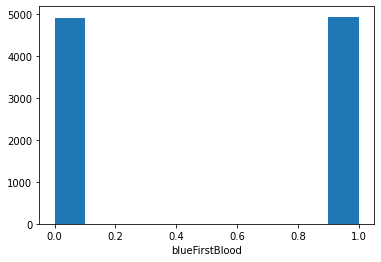

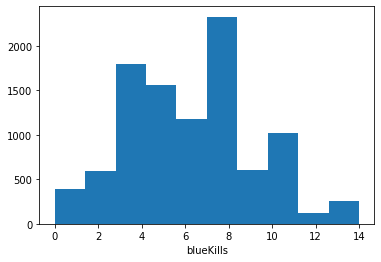

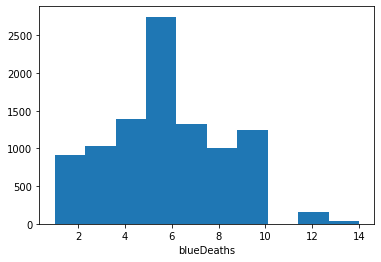

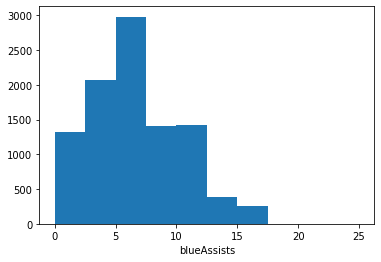

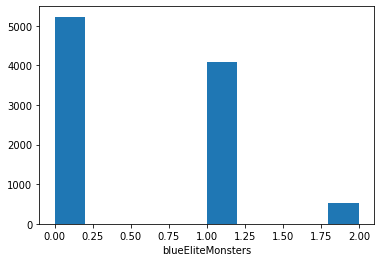

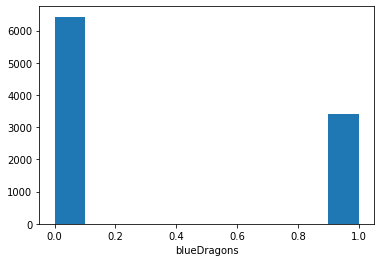

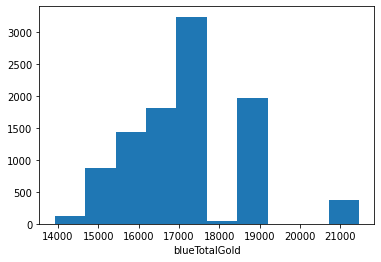

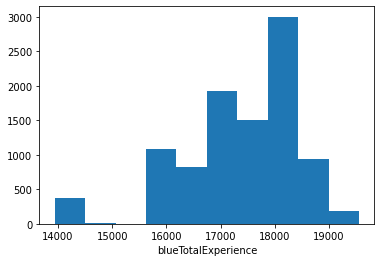

In [ ]:
for i in alldata.columns[3:]:
  plt.hist(alldata[i])
  plt.xlabel(i)
  plt.show()

In [ ]:
alldata.columns

Index(['blueWins', 'TrainFlag', 'gameId', 'blueFirstBlood', 'blueKills',
       'blueDeaths', 'blueAssists', 'blueEliteMonsters', 'blueDragons',
       'blueTotalGold', 'blueTotalExperience'],
      dtype='object')

ValueError: ignored

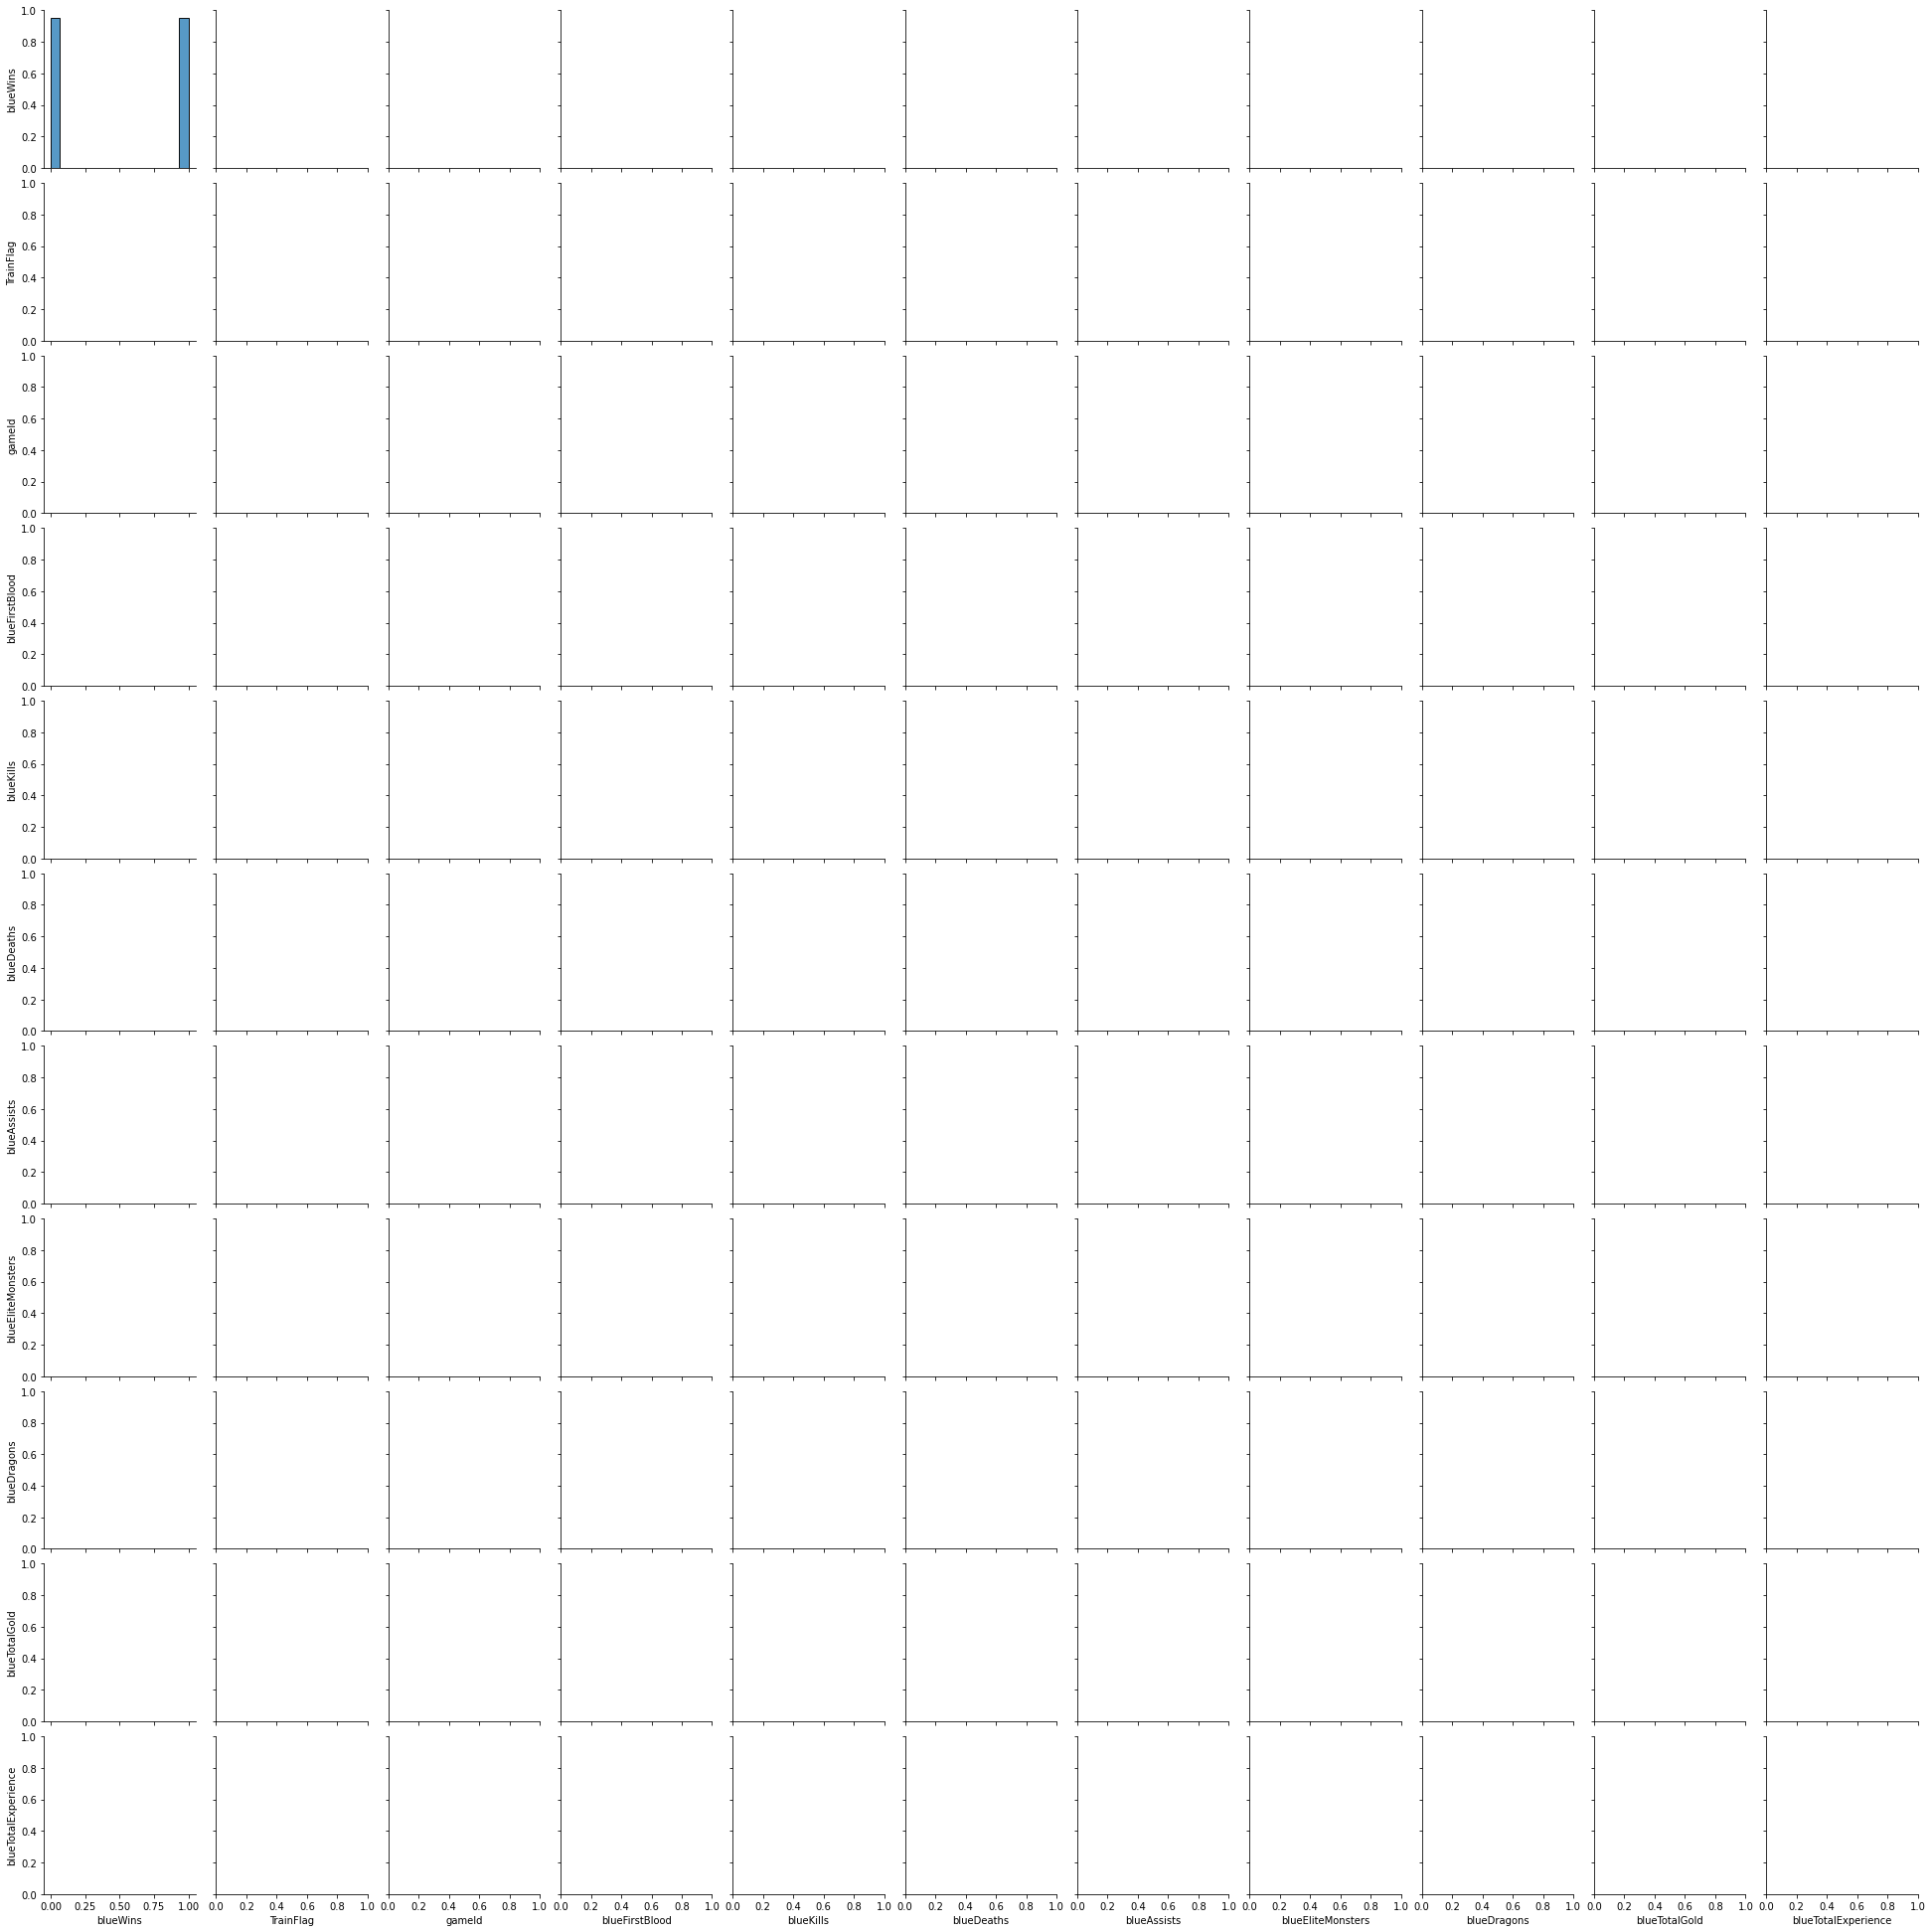

In [ ]:
sns.pairplot(alldata)
plt.show()

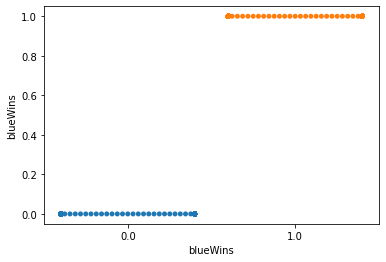

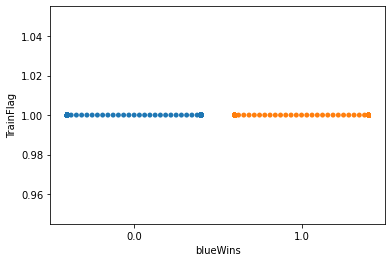

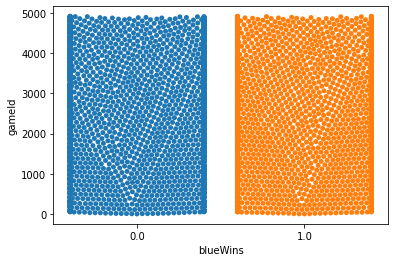

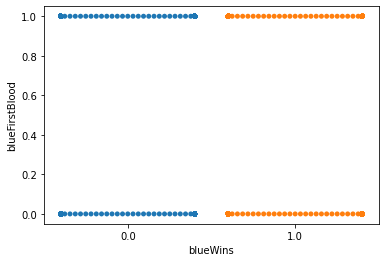

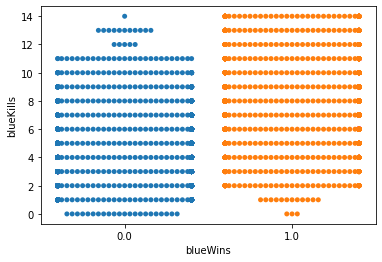

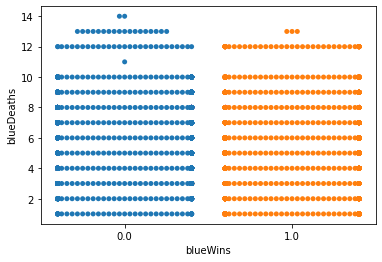

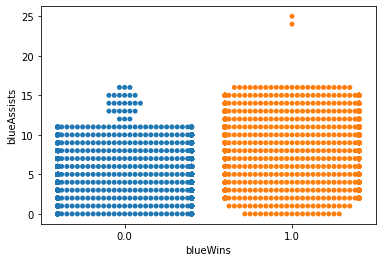

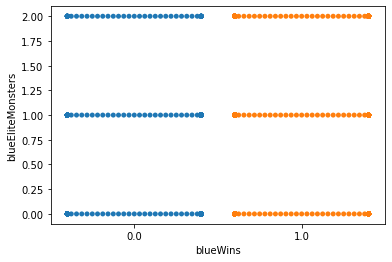

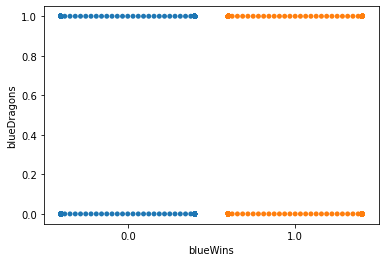

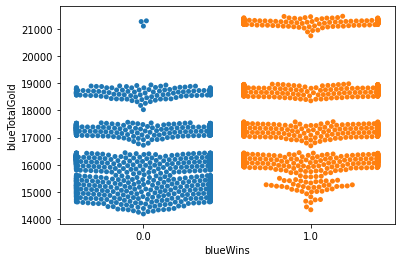

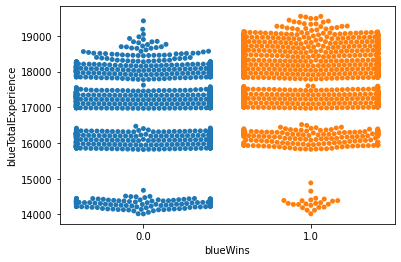

In [ ]:
for i in alldata.columns:
  sns.swarmplot("blueWins",i,data=alldata)
  plt.show()

#主成分分析

In [23]:
train2=train

In [24]:
train2

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins,TrainFlag
0,0,0,7,9,8,1,1,17398,17446,0,True
1,1,1,8,10,8,0,0,15925,14253,1,True
2,2,1,14,6,15,0,0,21457,19003,1,True
3,3,1,6,3,4,1,1,16364,17958,1,True
4,4,1,3,6,3,1,1,15451,16088,0,True
...,...,...,...,...,...,...,...,...,...,...,...
4920,4920,1,8,6,8,0,0,17489,17422,0,True
4921,4921,1,7,6,7,0,0,17296,16136,0,True
4922,4922,0,7,7,15,0,0,17287,17029,1,True
4923,4923,0,2,3,0,0,0,15283,16210,0,True


In [25]:
train2=train2.drop(["gameId","TrainFlag"],axis=1)

In [26]:
train2

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,7,9,8,1,1,17398,17446,0
1,1,8,10,8,0,0,15925,14253,1
2,1,14,6,15,0,0,21457,19003,1
3,1,6,3,4,1,1,16364,17958,1
4,1,3,6,3,1,1,15451,16088,0
...,...,...,...,...,...,...,...,...,...
4920,1,8,6,8,0,0,17489,17422,0
4921,1,7,6,7,0,0,17296,16136,0
4922,0,7,7,15,0,0,17287,17029,1
4923,0,2,3,0,0,0,15283,16210,0


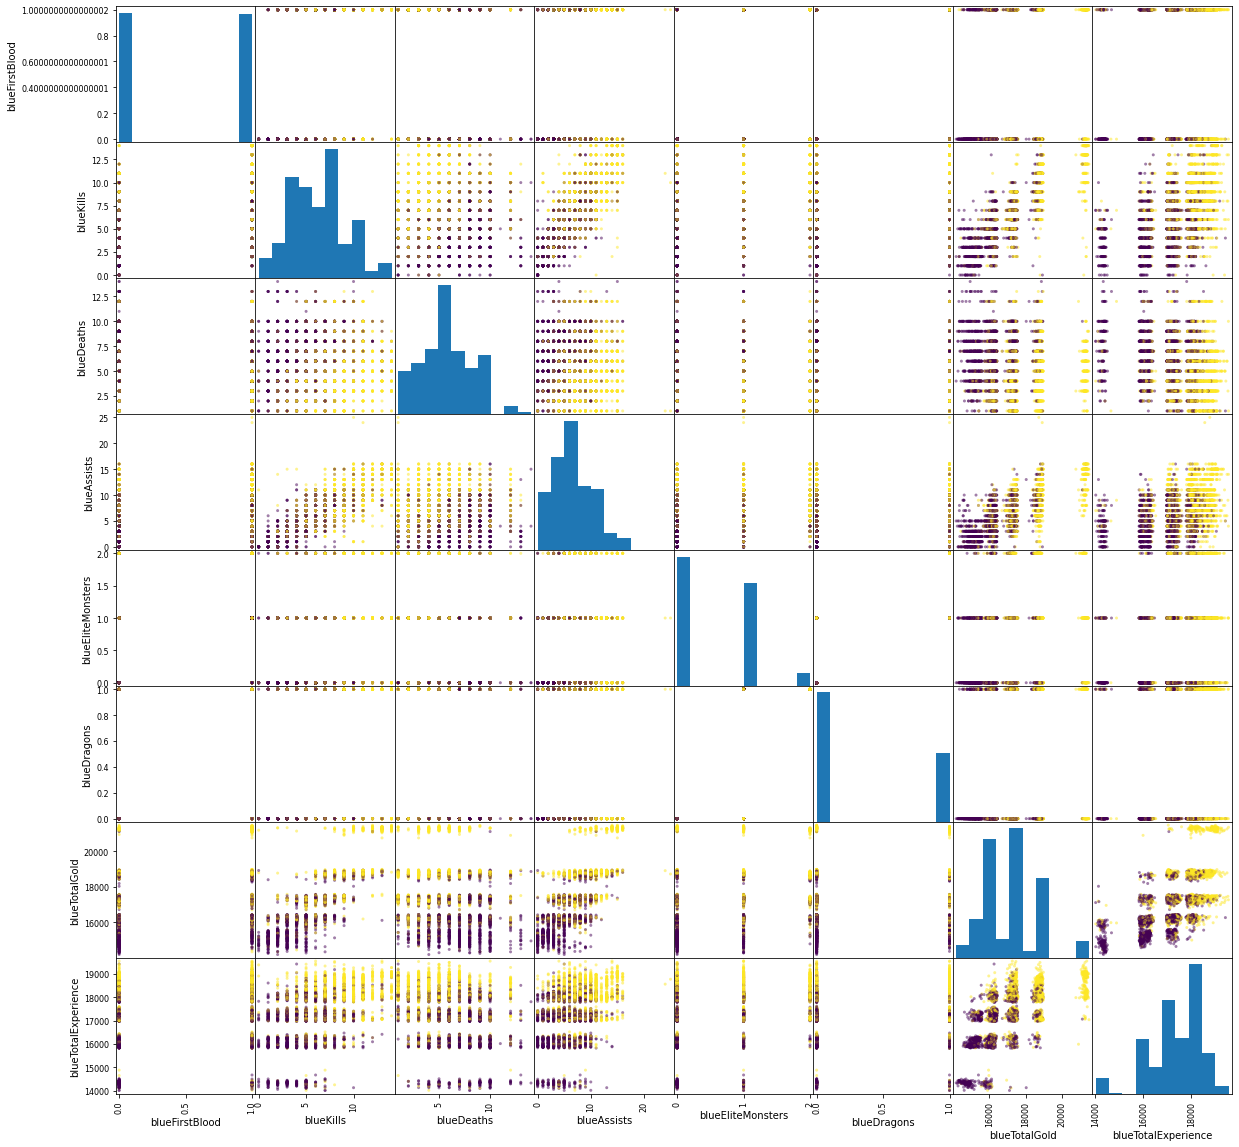

In [27]:

plotting.scatter_matrix(train2.iloc[:,:-1], figsize=(20, 20), c=list(train2.iloc[:, -1]), alpha=0.5)
plt.show()

In [28]:
#主成分分析器
#主成分分析の実行
pca = PCA()
pca.fit(train2[train2.columns[:-1]])
# データを主成分空間に写像
feature = pca.transform(train2[train2.columns[:-1]])

In [29]:
# 主成分得点
pca_df=pd.DataFrame(feature, columns=["PC{}".format(x + 1) for x in range(len(train2[train2.columns[:-1]].columns))])

pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,247.057361,61.941776,-2.800494,-1.941504,0.378387,0.809607,0.493385,-0.253336
1,-2697.269352,1984.416373,-4.012071,0.712924,-1.595536,-0.271378,-0.490982,0.033242
2,4513.025649,899.403086,-0.397820,-0.182059,-0.058678,-1.122615,-0.043399,-0.063102
3,-356.914003,-921.186696,0.765360,1.700839,-1.672097,0.603548,-0.382992,-0.220766
4,-2123.921638,177.979414,0.645166,0.183806,0.129731,1.099895,-0.653345,-0.210073


In [30]:
# 寄与率
pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(train2[train2.columns[:-1]].columns))])

,0
PC1,8.419490e-01
PC2,1.580465e-01
PC3,2.108009e-06
PC4,1.712318e-06
PC5,5.066399e-07
PC6,1.506567e-07
PC7,6.498639e-08
PC8,2.066299e-08


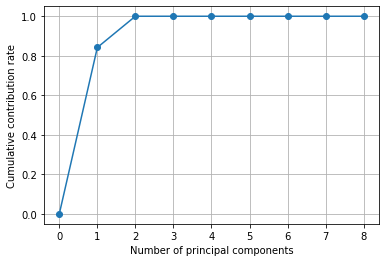

In [18]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

In [20]:
# PCA の固有値
pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(train2[train2.columns[:-1]].columns))])

,0
PC1,2.601681e+06
PC2,4.883747e+05
PC3,6.513895e+00
PC4,5.291184e+00
PC5,1.565553e+00
PC6,4.655398e-01
PC7,2.008125e-01
PC8,6.385008e-02


In [22]:
# PCA の固有ベクトル
pd.DataFrame(pca.components_, columns=train2.columns[:-1], index=["PC{}".format(x + 1) for x in range(len(train2[train2.columns[:-1]].columns))])

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
PC1,0.000105,0.001413,-0.000227,0.001560,0.000102,0.000068,0.847184,0.531295
PC2,0.000069,0.001275,0.001028,0.001597,-0.000058,-0.000038,0.531292,-0.847186
PC3,-0.008286,-0.374062,-0.564722,-0.735562,0.000846,-0.006167,0.002499,-0.001068
PC4,0.043187,0.173266,-0.820583,0.541168,0.030512,0.031012,-0.001217,-0.000478
PC5,-0.071372,-0.905436,0.070415,0.407476,-0.049753,-0.040261,0.000801,-0.000007
PC6,0.068871,-0.072235,0.040830,0.000537,0.796304,0.595207,0.000044,-0.000106
PC7,-0.993734,0.070769,-0.033224,0.000601,0.076225,0.023874,-0.000002,-0.000022
PC8,0.026862,0.003529,-0.001611,0.006546,0.597230,-0.801584,-0.000027,-0.000004


In [31]:
alldata["PC1"]=alldata["blueFirstBlood"]*0.000105+alldata["blueKills"]*0.001413+alldata["blueDeaths"]*(-0.000227)+alldata["blueAssists"]*0.001560+alldata["blueEliteMonsters"]*0.000102+alldata["blueDragons"]*0.000068+alldata["blueTotalGold"]*0.847184+alldata["blueTotalExperience"]*0.531295

In [32]:
alldata["PC2"]=alldata["blueFirstBlood"]*0.000069+alldata["blueKills"]*0.001275+alldata["blueDeaths"]*(-0.001028)+alldata["blueAssists"]*0.001597+alldata["blueEliteMonsters"]*(-0.000058)+alldata["blueDragons"]*(-0.000038)+alldata["blueTotalGold"]*0.531292+alldata["blueTotalExperience"]*(-0.847186)

#trainととtestに分ける

In [33]:
alldata["total"]=alldata["blueKills"].values-alldata["blueDeaths"].values
alldata["total2"]=alldata["blueKills"].values-alldata["blueDeaths"].values+alldata["blueAssists"].values
alldata["total_pm"]=np.sign(alldata["blueKills"].values-alldata["blueDeaths"].values)
alldata["total_exp"]=alldata["blueTotalGold"].values+alldata["blueTotalExperience"].values
# alldata=alldata.drop(["blueDragons","blueEliteMonsters","blueTotalGold","blueTotalExperience","blueKills","blueDeaths","blueFirstBlood"],axis=1)
train=alldata.loc[alldata.TrainFlag]
train=train.drop("TrainFlag",axis=1)
train=train.drop("gameId",axis=1)
train["blueWins"]=train["blueWins"].astype('int')

train.head()

,blueWins,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
0,0,0,7,9,8,1,1,17398,17446,24008.300300,-5536.576387,-2,6,-1,34844
1,1,1,8,10,8,0,0,15925,14253,21063.974454,-3614.104193,-2,6,-1,30178
2,1,1,14,6,15,0,0,21457,19003,28274.267898,-4699.107408,8,23,1,40460
3,1,1,6,3,4,1,1,16364,17958,23404.328898,-6519.692973,3,7,1,34322
4,0,1,3,6,3,1,1,15451,16088,21637.321776,-5420.533255,-3,0,-1,31539


In [34]:
#標準化標準化
# 説明変数を標準化
sc = StandardScaler()
train[train.columns[1:]] = sc.fit_transform(train[train.columns[1:]])
train.head()

,blueWins,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
0,0,-0.997364,0.267314,1.285473,0.458354,0.790611,1.371788,0.171065,0.075650,0.153185,0.088635,-0.656109,-0.122747,-1.119748,0.143677
1,1,1.002643,0.613493,1.683947,0.458354,-0.883404,-0.728976,-0.869275,-2.990171,-1.672404,2.839875,-0.656109,-0.122747,-1.119748,-1.944809
2,1,1.002643,2.690570,0.090051,2.406541,-0.883404,-0.728976,3.037825,1.570634,2.798239,1.287132,2.017731,2.463311,1.000905,2.657379
3,1,1.002643,-0.078866,-1.105371,-0.654896,0.790611,1.371788,-0.559221,0.567257,-0.221300,-1.318298,0.680811,0.029374,1.000905,-0.089969
4,0,1.002643,-1.117404,0.090051,-0.933209,0.790611,1.371788,-1.204048,-1.228260,-1.316908,0.254704,-0.923493,-1.035473,-1.119748,-1.335630


In [35]:
train.corr().style.background_gradient("summer_r")

,blueWins,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
blueWins,1.000000,0.264161,0.464699,-0.230276,0.412116,0.265001,0.247713,0.502566,0.447235,0.527224,-0.023685,0.513446,0.517367,0.468111,0.526984
blueFirstBlood,0.264161,1.000000,0.397912,-0.146925,0.333501,0.167185,0.177237,0.353209,0.224516,0.339727,0.096752,0.405931,0.413230,0.362284,0.328506
blueKills,0.464699,0.397912,1.000000,0.045194,0.813118,0.238382,0.223069,0.842222,0.473838,0.788969,0.308382,0.742059,0.866612,0.609222,0.754640
blueDeaths,-0.230276,-0.146925,0.045194,1.000000,0.031210,-0.144199,-0.137468,-0.065704,-0.282732,-0.145869,0.286269,-0.636113,-0.344841,-0.547132,-0.173439
blueAssists,0.412116,0.333501,0.813118,0.031210,1.000000,0.196889,0.197963,0.757272,0.399697,0.700352,0.310548,0.607098,0.891976,0.497242,0.666241
blueEliteMonsters,0.265001,0.167185,0.238382,-0.144199,0.196889,1.000000,0.765560,0.249164,0.266292,0.276677,-0.068009,0.280883,0.267417,0.244482,0.282042
blueDragons,0.247713,0.177237,0.223069,-0.137468,0.197963,0.765560,1.000000,0.207481,0.220850,0.230085,-0.055502,0.264539,0.258706,0.226696,0.234442
blueTotalGold,0.502566,0.353209,0.842222,-0.065704,0.757272,0.249164,0.207481,1.000000,0.644924,0.965013,0.262205,0.694609,0.809092,0.558206,0.934385
blueTotalExperience,0.447235,0.224516,0.473838,-0.282732,0.399697,0.266292,0.220850,0.644924,1.000000,0.822748,-0.568405,0.555704,0.534621,0.473125,0.874881
PC1,0.527224,0.339727,0.788969,-0.145869,0.700352,0.276677,0.230085,0.965013,0.822748,1.000000,0.000002,0.707269,0.785183,0.577489,0.995107


In [36]:
test=alldata.loc[~alldata.TrainFlag]
test=test[test.columns[1:]]
test=test.drop("TrainFlag",axis=1)
test=test.drop("gameId",axis=1)
test.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
0,0,6,10,3,0,0,14872,14277,20184.630051,-4193.897737,-4,-1,-1,29149
1,0,1,7,2,0,0,16046,16238,22221.085618,-5231.497563,-6,-4,-1,32284
2,0,2,9,3,0,0,15432,17274,22251.338781,-6435.394731,-7,-4,-1,32706
3,0,7,7,6,1,1,17421,17284,23941.713076,-5387.113677,0,6,0,34705
4,0,3,4,5,0,0,16160,17439,22955.758076,-6188.390236,-1,4,-1,33599


In [37]:
#標準化標準化
# 説明変数を標準化
sc = StandardScaler()
test[test.columns[:]] = sc.fit_transform(test[test.columns[:]])
test.head()

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
0,-1.00795,-0.073790,1.690722,-0.945440,-0.867165,-0.729302,-1.626033,-2.923904,-2.222849,1.988172,-1.206620,-1.205082,-1.140579,-2.404351
1,-1.00795,-1.819305,0.488179,-1.226481,-0.867165,-0.729302,-0.782545,-1.053035,-0.946141,0.508319,-1.751463,-1.668974,-1.140579,-0.989614
2,-1.00795,-1.470202,1.289874,-0.945440,-0.867165,-0.729302,-1.223688,-0.064651,-0.927175,-1.208711,-2.023885,-1.668974,-1.140579,-0.799177
3,-1.00795,0.275313,0.488179,-0.102316,0.803068,1.371174,0.205356,-0.055110,0.132566,0.286375,-0.116934,-0.122668,-0.073656,0.102916
4,-1.00795,-1.121099,-0.714363,-0.383357,-0.867165,-0.729302,-0.700639,0.092765,-0.485555,-0.856427,-0.389355,-0.431929,-1.140579,-0.396191


#Predict

##XGBoost

In [38]:
def xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts):
    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    #xgb_test = xgb.DMatrix(X_test, label=y_test)

    xgb_params = {
        'objective':  'binary:logistic',#'loss_function': 'RMSE',  # 多値分類問題
        # # 'num_class': 2,                 # 目的変数のクラス数
        # 'learning_rate': 0.1,           # 学習率
        # # 'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'logloss',
        # 'eval_metric': 'rmse',
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,                 # 目的変数のクラス数
        'learning_rate': 0.1,           # 学習率
        # 'eval_metric': 'mlogloss'       # 学習用の指標 (Multiclass logloss)
    }
    # xgb_params = {
    #     "silent": 0,
    #     "max_depth": 50,
    #     "min_child_weight": 1,
    #     "eta": 0.2,
    #     "tree_method": "exact",
    #     "objective": 'reg:squarederror',
    #     "eval_metric": "rmse",
    #     # "predictor": "cpu_predictor" 
    #     'random_state':1234,
    #     }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst = xgb.train(xgb_params,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )

    print(xgb.plot_importance(bst))

    
    
    # 検証用データで予測
    y_pred = bst.predict(xgb_eval, ntree_limit=bst.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)

    # model =XGBClassifier()
    # model=model.fit(X_train_cv,y_train_cv)
    # y_pred =model.predict(X_eval_cv)

    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    print('Trial: ' + str(loop_counts))
    
    # Accuracy の計算
    accuracy = accuracy_score(y_eval_cv, y_pred_max)
    print('XGBoost Accuracy:', accuracy)

    # plt.plot(evaluation_results["train"]["rmse"], color = "red", label = "train")
    # plt.plot(evaluation_results["eval"]["rmse"], color = "blue", label = "eval")
    # plt.legend()
    # plt.show()

    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('XGBoost RMSE:', rmse_result)
    
    # return(bst, rmse_result,y_pred)
    return(bst, accuracy,y_pred)

##LightGBM

In [39]:
def lgbm_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',                # レーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              # 'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              # 'objective': 'regression',
              # 'metric': 'rmse',      # 検証用データセットで、分類モデルの性能を測る指標
              # 'num_class': 3,                 # 目的変数のクラス数

              'objective': 'binary', # 目的 : 2クラス分類
              'metric': {'binary_error'}, # 評価指標 : 誤り率(= 1-正答率)
              # 'objective': 'multiclass', # 目的関数：多値分類、マルチクラス分類 
              # 'metric': 'multi_logloss', # 検証用データセットで、分類モデルの性能を測る指標 
              # 'num_class': 2, # 目的変数のクラス数 

              'learning_rate': 0.1,           # 学習率（初期値0.1）
              'num_leaves': 40,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }

    # 学習
    evaluation_results = {}                                # 学習の経過を保存する箱
    LGBM_model = lgb.train(params,                              # 上記で設定したパラメータ
                      lgb_train,                           # 使用するデータセット
                      num_boost_round=1000,                 # 学習の回数
                      valid_names=['train', 'valid'],      # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],    # モデルの検証に使用するデータセット
                      evals_result=evaluation_results,     # 学習の経過を保存
                      early_stopping_rounds=5,            # アーリーストッピングの回数
                      verbose_eval=0)                      # 学習の経過を表示する刻み（非表示）

    # 検証用データで予測
    y_pred = LGBM_model.predict(X_eval_cv, num_iteration=LGBM_model.best_iteration)
    # y_pred_max = np.argmax(y_pred)
    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # Accuracy の計算
    accuracy =accuracy_score(y_eval_cv, y_pred_max)
    print('LightGBM Accuracy:', accuracy)
    
    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('LightGBM RMSE:', rmse_result)
    
    # return(LGBM_model, rmse_result,y_pred)
    return(LGBM_model, accuracy, y_pred)

##Catboost

In [40]:
def catboost_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv):
    # データを格納する
    # 学習用
    CatBoost_train = Pool(X_train_cv, label=y_train_cv)
    # 検証用
    CatBoost_eval = Pool(X_eval_cv, label=y_eval_cv)

    # パラメータを設定
    params = {        
        # 'loss_function': 'RMSE',    # 多値分類問題
        'num_boost_round': 1000,          # 学習の回数
        'early_stopping_rounds': 5,       # アーリーストッピングの回数
        # 'loss_function': 'MultiClass',
    }

    # 学習
    catb = CatBoost(params)
    catb.fit(CatBoost_train, eval_set=[CatBoost_eval], verbose=False)

    # 検証用データで予測
    # y_pred = catb.predict(X_eval_cv)
    y_pred = catb.predict(X_eval_cv,prediction_type='RawFormulaVal')#RawFormulaValは生のデータという意味で、0〜1間の数値をとります。(予測が0.6432..のようになります。)
    # y_pred = catb.predict(X_eval_cv,prediction_type='Probability')
    # y_pred_max = np.argmax(y_pred, axis=1)

    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

    # Accuracy の計算
    accuracy = sum(y_eval_cv == y_pred_max) / len(y_eval_cv)
    print('CatBoost Accuracy:', accuracy)

    # rmse_result=np.sqrt(mean_squared_error(y_eval_cv, y_pred))
    # print('CatBoost RMSE:', rmse_result)
    
    # return(catb, rmse_result,y_pred)
    return(catb, accuracy,y_pred)

##1段目

AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 1
XGBoost Accuracy: 0.7878172588832487
LightGBM Accuracy: 0.783756345177665
CatBoost Accuracy: 0.7908629441624365
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 2
XGBoost Accuracy: 0.7614213197969543
LightGBM Accuracy: 0.7573604060913706
CatBoost Accuracy: 0.7604060913705584
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 3
XGBoost Accuracy: 0.7532994923857868
LightGBM Accuracy: 0.749238578680203
CatBoost Accuracy: 0.7563451776649747
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 4
XGBoost Accuracy: 0.749238578680203
LightGBM Accuracy: 0.7553299492385787
CatBoost Accuracy: 0.7624365482233503
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 5
XGBoost Accuracy: 0.7461928934010152
LightGBM Accuracy: 0.749238578680203
CatBoost Accuracy: 0.7573604060913706
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 6
XGBoost Accuracy: 0.7878172588832487
LightGBM Accuracy: 0.783756345177665
CatBoost Accuracy: 0.7908629441624365
AxesSubplot(0.125,0.125;0.775x0.755)
Trial: 7
XGBoo

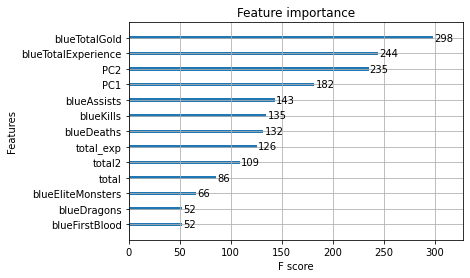

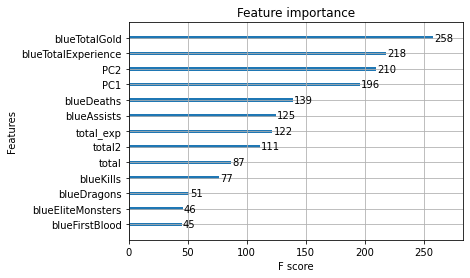

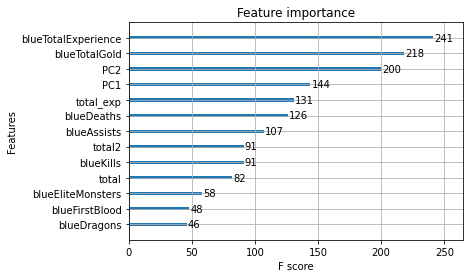

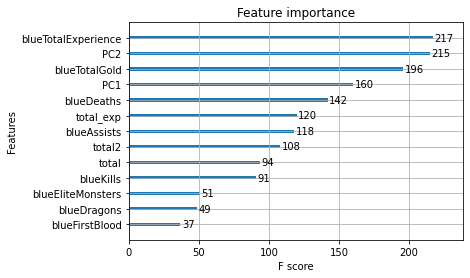

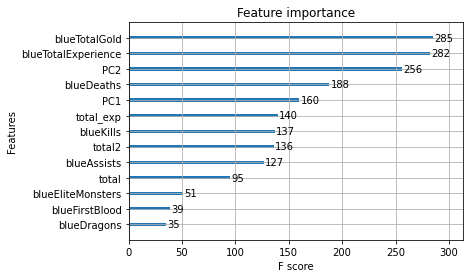

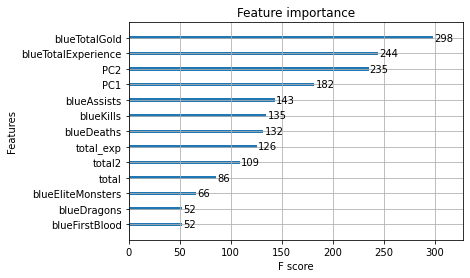

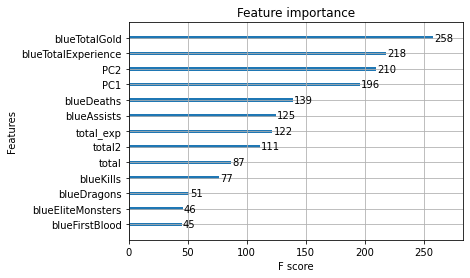

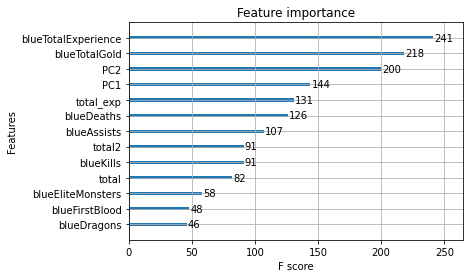

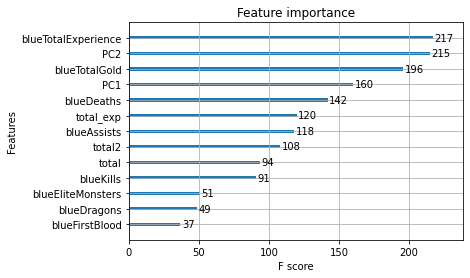

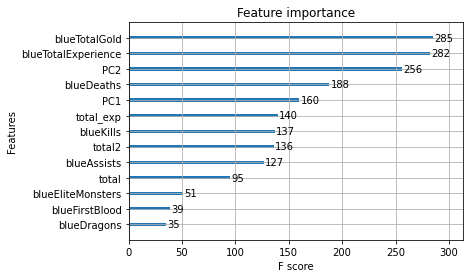

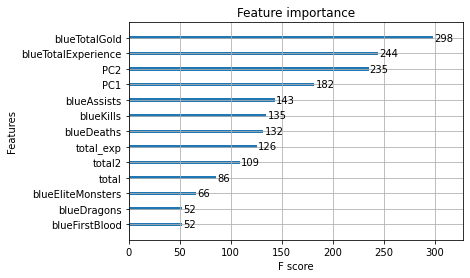

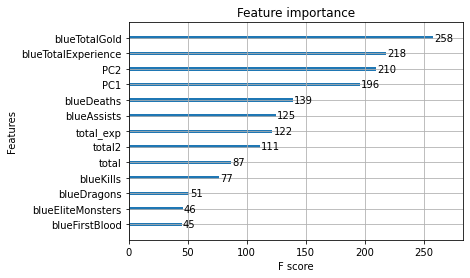

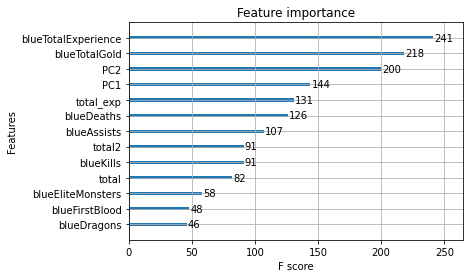

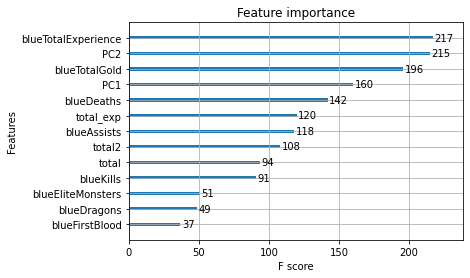

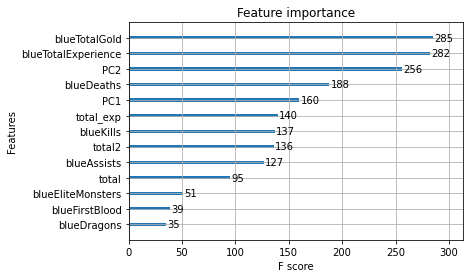

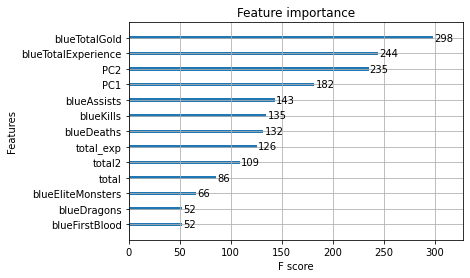

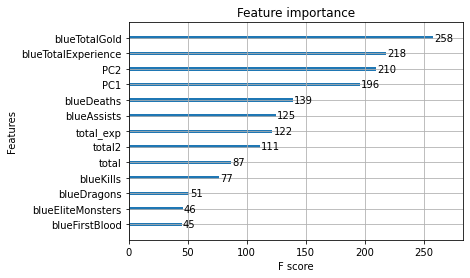

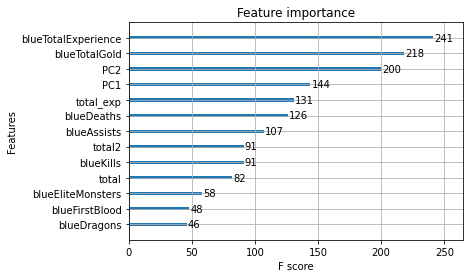

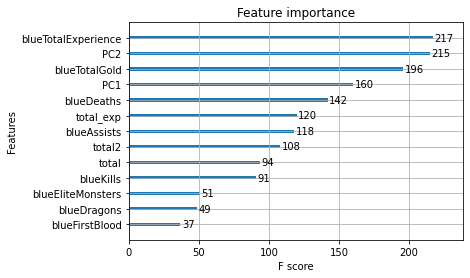

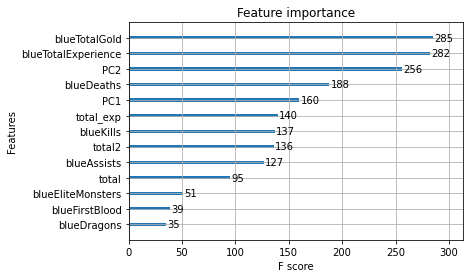

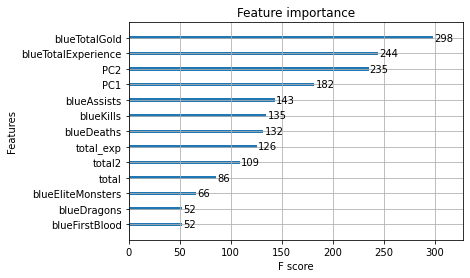

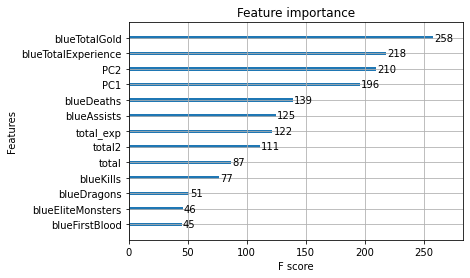

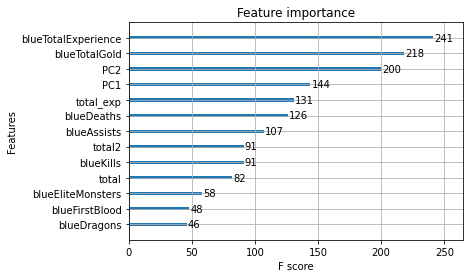

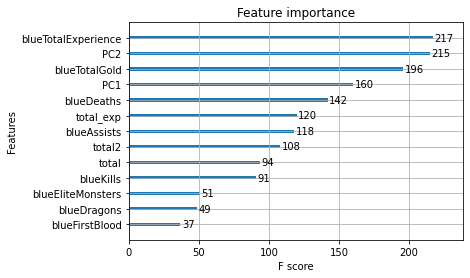

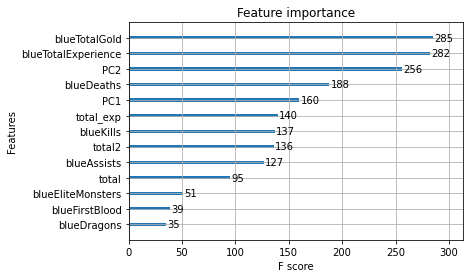

In [41]:
# 各5つのモデルを保存するリストの初期化
xgb_models = []
lgbm_models = []
catb_models = []
# 各5つのモデルの正答率を保存するリストの初期化
xgb_rmse_result = []
lgbm_rmse_result = []
catb_rmse_result = []
# 学習のカウンター
loop_counts = 1

# X=train[train.columns[1:]].values
# Y=train[train.columns[0]].values
df_X=train[train.columns[1:]]
y= train[train.columns[0]]

# # 各クラスの確率（3モデル*5seed*1クラス）
first_preds = pd.DataFrame(np.zeros((len(df_X), 3*5)))
first_prebs = pd.DataFrame(np.zeros((len(df_X), 3*5*2)))



for seed_no in range(5): 
        
    # 学習データの数だけの数列（0行から最終行まで連番）
    row_no_list = list(range(len(df_X)))

    # KFoldクラスをインスタンス化（これを使って5分割する）Stratified Kfoldは、分類問題にしか使えません
    K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)
    # #＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
    # num_bins = int(np.floor(1+np.log2(len(y))))
    # y_bin = pd.cut(y, bins=num_bins, labels=False)
    

    # KFoldクラスで分割した回数だけ実行（ここでは5回）
    # for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_bin):
    for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y):
        # ilocで取り出す行を指定
        X_train_cv = df_X.iloc[train_cv_no, :]
        y_train_cv = pd.Series(y).iloc[train_cv_no]
        X_eval_cv = df_X.iloc[eval_cv_no, :]
        y_eval_cv = pd.Series(y).iloc[eval_cv_no]
        
        # XGBoostの訓練を実行
        bst, bst_rmse, bst_pred = xgb_train_cv(X_train_cv, y_train_cv, X_eval_cv, y_eval_cv, loop_counts)
        # LIghtGBMの訓練を実行
        LGBM_model, model_rmse, model_pred = lgbm_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # CatBoostの訓練を実行
        catb, catb_rmse, catb_pred = catboost_train_cv(X_train_cv, y_train_cv,X_eval_cv, y_eval_cv)
        # 実行回数のカウント
        loop_counts += 1
        
        # 学習が終わったモデルをリストに入れておく
        xgb_models.append(bst) 
        lgbm_models.append(LGBM_model) 
        catb_models.append(catb) 
        
        # 学習が終わったモデルの正答率をリストに入れておく
        xgb_rmse_result.append(bst_rmse) 
        lgbm_rmse_result.append(model_rmse) 
        catb_rmse_result.append(catb_rmse) 
        
        # # 検証データの各クラスの確率
        # for i in range(2):
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + i] = bst_pred[:, i]
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + 10 + i] = model_pred[:, i]
        #     first_prebs.iloc[eval_cv_no, (seed_no * 2) + 20 + i] = catb_pred[:, i]

        # # 検証データの結果
        first_preds.iloc[eval_cv_no, (seed_no * 3) ] =bst_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 1] = model_pred
        first_preds.iloc[eval_cv_no, (seed_no * 3) + 2] = catb_pred

In [42]:
first_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.435865,0.444308,0.407788,0.435865,0.444308,0.407788,0.435865,0.444308,0.407788,0.435865,0.444308,0.407788,0.435865,0.444308,0.407788
1,0.209818,0.347061,0.157581,0.209818,0.347061,0.157581,0.209818,0.347061,0.157581,0.209818,0.347061,0.157581,0.209818,0.347061,0.157581
2,0.952186,0.586140,0.925012,0.952186,0.586140,0.925012,0.952186,0.586140,0.925012,0.952186,0.586140,0.925012,0.952186,0.586140,0.925012
3,0.709463,0.597778,0.649528,0.709463,0.597778,0.649528,0.709463,0.597778,0.649528,0.709463,0.597778,0.649528,0.709463,0.597778,0.649528
4,0.183103,0.231572,0.203932,0.183103,0.231572,0.203932,0.183103,0.231572,0.203932,0.183103,0.231572,0.203932,0.183103,0.231572,0.203932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,0.507989,0.532005,0.532808,0.507989,0.532005,0.532808,0.507989,0.532005,0.532808,0.507989,0.532005,0.532808,0.507989,0.532005,0.532808
4921,0.483156,0.540226,0.449033,0.483156,0.540226,0.449033,0.483156,0.540226,0.449033,0.483156,0.540226,0.449033,0.483156,0.540226,0.449033
4922,0.270103,0.360874,0.317515,0.270103,0.360874,0.317515,0.270103,0.360874,0.317515,0.270103,0.360874,0.317515,0.270103,0.360874,0.317515
4923,0.136796,0.295614,0.118033,0.136796,0.295614,0.118033,0.136796,0.295614,0.118033,0.136796,0.295614,0.118033,0.136796,0.295614,0.118033


In [43]:
# 単独のモデルでの、テストデータの正答率
#スタッキングによる予測の１段目は、特徴量の抽出が目的なので、ここでの正答率はあまり気にしないでよいです。
print('XGBoost RMSE: ', np.array(xgb_rmse_result).mean())
print('LightGBM RMSE: ', np.array(lgbm_rmse_result).mean())
print('CatBoost RMSE: ', np.array(catb_rmse_result).mean())

XGBoost RMSE:  0.7595939086294416
LightGBM RMSE:  0.758984771573604
CatBoost RMSE:  0.7654822335025381


##スタッキングによる予測

In [44]:
loop_counts = 0

# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

# 予測結果の格納用のnumpy行列を作成
test_preds = np.zeros((len(y_test), 5))

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)
# #＃回帰問題でも＃回帰問題でもStratifiedKFoldが使えるように以下追記
# num_bins2 = int(np.floor(1+np.log2(len(y_train))))
# y_train_bin = pd.cut(y_train, bins=num_bins2, labels=False)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
# for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train_bin):
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]

    # データを格納する
    # 学習用
    xgb_train = xgb.DMatrix(X_train_cv, label=y_train_cv)
    # 検証用
    xgb_eval = xgb.DMatrix(X_eval_cv, label=y_eval_cv)
    # テスト用
    xgb_test = xgb.DMatrix(X_test, label=y_test)

    xgb_params2 = {
        'objective':  'binary:logistic',
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,                 # 目的変数のクラス数
        'learning_rate': 0.1,           # 学習率
        # 'eval_metric': 'mlogloss',       # 学習用の指標 (Multiclass logloss)
        'eval_metric': 'logloss',
        'random_state':1234,
        # 'objective': 'multi:softprob',  # 多値分類問題
        # 'num_class': 2,
    }
    # xgb_params2 = {
    #     "silent": 0,
    #     "max_depth": 10,
    #     "min_child_weight": 1,
    #     "eta": 0.1,
    #     "tree_method": "exact",
    #     "objective": 'reg:squarederror',
    #     "eval_metric": "rmse",
    #     # "predictor": "cpu_predictor" 
    #     'random_state':1234,
    #     }

    # 学習
    evals = [(xgb_train, 'train'), (xgb_eval, 'eval')] # 学習に用いる検証用データ
    evaluation_results = {}                            # 学習の経過を保存する箱
    bst2 = xgb.train(xgb_params2,                        # 上記で設定したパラメータ
                    xgb_train,                         # 使用するデータセット
                    num_boost_round=1000,               # 学習の回数
                    early_stopping_rounds=5,          # アーリーストッピング
                    evals=evals,                       # 学習経過で表示する名称
                    evals_result=evaluation_results,   # 上記で設定した検証用データ
                    verbose_eval=0                     # 学習の経過の表示(非表示)
                    )


    y_pred = bst2.predict(xgb_test, ntree_limit=bst2.best_ntree_limit)
    # y_pred_max = np.argmax(y_pred, axis=1)
    y_pred_max=np.where(y_pred < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す
    # y_pred_max = np.argmax(y_pred, axis=1)

    # testの予測を保存
    # test_preds[:, loop_counts] = y_pred
    test_preds[:, loop_counts] = y_pred_max
 
    print('Trial: ' + str(loop_counts))
    loop_counts += 1
    # Accuracy の計算
    accuracy = accuracy_score(y_test, y_pred_max)
    print('Accuracy:', accuracy)
    
    # rmse__ = np.sqrt(mean_squared_error(y_test, y_pred))
    # print('RMSE:', rmse__)

Trial: 0
Accuracy: 0.7258883248730964
Trial: 1
Accuracy: 0.7360406091370558
Trial: 2
Accuracy: 0.7248730964467005
Trial: 3
Accuracy: 0.7137055837563452
Trial: 4
Accuracy: 0.7269035532994924


In [45]:
import optuna

#学習データを説明変数と目的変数に分ける
# X=df_co_train[df_co_train.columns[1:]].values
# Y=df_co_train[df_co_train.columns[0]].values
X=train[train.columns[1:]].values
Y=train[train.columns[0]].values

# データを訓練データと正解データに7:3で分ける
X_train, X_test, y_train, y_test = train_test_split(first_preds, y.values,
                                                    test_size=0.2,
                                                    random_state=0)

#データをXGB専用のデータ型に変換
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
  # 探索したいパラメータの範囲を記述 例えば、trial.suggest_int(“max_depth”, 6, 9)ならmax_depthを6,7,8,9の中で動かしながら探索
  params = {
        "silent": 0,
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "min_child_weight": 1,
        "eta": trial.suggest_loguniform("eta", 0.01, 0.3),
        "tree_method": "exact",
        "objective": 'binary:logistic',
        'eval_metric': 'logloss',
        # "objective": 'reg:squarederror',
        # "eval_metric": "rmse",
        # "predictor": "cpu_predictor" 
        'random_state':1234,  
    }
    # モデル定義、学習
  cv_results = xgb.cv(
      params,
      dtrain,
      num_boost_round=1000,
      seed=1234,
      nfold=5, # CVの分割数
      # metrics={"rmse"},
      early_stopping_rounds=10
      )
    # 評価

  # return cv_results["test-rmse-mean"].min()
  return cv_results["test-logloss-mean"].min()

study=optuna.create_study()
study.optimize(objective,n_trials=50)

[I 2022-01-28 12:17:33,496] A new study created in memory with name: no-name-7cc41d77-890b-4ed5-a975-b5b6af98bff7
[I 2022-01-28 12:17:42,916] Trial 0 finished with value: 0.4995322 and parameters: {'max_depth': 10, 'eta': 0.012348257238964867}. Best is trial 0 with value: 0.4995322.
[I 2022-01-28 12:17:43,737] Trial 1 finished with value: 0.486918 and parameters: {'max_depth': 6, 'eta': 0.16517864735980153}. Best is trial 1 with value: 0.486918.
[I 2022-01-28 12:17:44,987] Trial 2 finished with value: 0.4855342 and parameters: {'max_depth': 6, 'eta': 0.0924691096013945}. Best is trial 2 with value: 0.4855342.
[I 2022-01-28 12:17:47,422] Trial 3 finished with value: 0.4959656 and parameters: {'max_depth': 9, 'eta': 0.050687967652082416}. Best is trial 2 with value: 0.4855342.
[I 2022-01-28 12:17:50,942] Trial 4 finished with value: 0.49277800000000005 and parameters: {'max_depth': 8, 'eta': 0.03216169627816468}. Best is trial 2 with value: 0.4855342.
[I 2022-01-28 12:17:53,449] Trial 5 

In [46]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  50
Best trial:
  Value: 0.4845604
  Params: 
    max_depth: 6
    eta: 0.020343137907593893


[0]	train-logloss:0.684903	eval-logloss:0.686301
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 3 rounds.
[1]	train-logloss:0.676989	eval-logloss:0.679778
[2]	train-logloss:0.669381	eval-logloss:0.673564
[3]	train-logloss:0.662069	eval-logloss:0.66757
[4]	train-logloss:0.654945	eval-logloss:0.661777
[5]	train-logloss:0.648126	eval-logloss:0.65631
[6]	train-logloss:0.641509	eval-logloss:0.650989
[7]	train-logloss:0.635165	eval-logloss:0.645984
[8]	train-logloss:0.628997	eval-logloss:0.640958
[9]	train-logloss:0.622936	eval-logloss:0.63642
[10]	train-logloss:0.617086	eval-logloss:0.63194
[11]	train-logloss:0.611642	eval-logloss:0.627486
[12]	train-logloss:0.606341	eval-logloss:0.623388
[13]	train-logloss:0.601108	eval-logloss:0.619518
[14]	train-logloss:0.596029	eval-logloss:0.615835
[15]	train-logloss:0.591112	eval-logloss:0.612345
[16]	train-logloss:0.586394	eval-logloss:0.608733
[17]	train-loglo

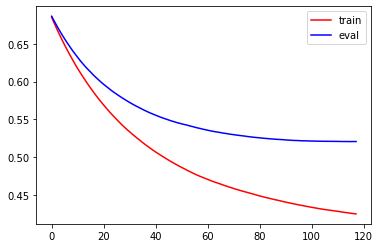

In [47]:
#訓練データはdtrain、評価用のテストデータはdvalidと設定
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
params = {
      "silent": 0,
      "max_depth": 50,
      "min_child_weight": 1,
      "eta": 0.20176532503411956,
      "tree_method": "exact",
      # "objective": 'reg:squarederror',
      "objective": 'binary:logistic',
      # "eval_metric": "rmse",
      'eval_metric': 'logloss',
      # "predictor": "cpu_predictor" 
      'random_state':1234,  
  }
params["max_depth"] = trial.params["max_depth"]
params["eta"] = trial.params["eta"]
results_dict = {}
XGBmodel2 = xgb.train(params=params,
                  dtrain=dtrain,
                  num_boost_round=10000,
                  early_stopping_rounds=3,
                  evals=watchlist,
                  evals_result = results_dict,
                  )
plt.plot(results_dict["train"]["logloss"], color = "red", label = "train")
plt.plot(results_dict["eval"]["logloss"], color = "blue", label = "eval")
plt.legend()
plt.show()

In [48]:
# # 混同行列の計算
# df_accuracy = pd.DataFrame({'va_y': y_test,
#                             'y_pred_max': y_pred_max})
# pd.crosstab(df_accuracy['va_y'], df_accuracy['y_pred_max'])

#提出

In [49]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
3570,0.932877,0.586140,0.895882,0.932877,0.586140,0.895882,0.932877,0.586140,0.895882,0.932877,0.586140,0.895882,0.932877,0.586140,0.895882
2886,0.717552,0.662244,0.723971,0.717552,0.662244,0.723971,0.717552,0.662244,0.723971,0.717552,0.662244,0.723971,0.717552,0.662244,0.723971
3309,0.096345,0.238524,0.138695,0.096345,0.238524,0.138695,0.096345,0.238524,0.138695,0.096345,0.238524,0.138695,0.096345,0.238524,0.138695
854,0.915330,0.625775,0.931869,0.915330,0.625775,0.931869,0.915330,0.625775,0.931869,0.915330,0.625775,0.931869,0.915330,0.625775,0.931869
1531,0.333447,0.349951,0.259877,0.333447,0.349951,0.259877,0.333447,0.349951,0.259877,0.333447,0.349951,0.259877,0.333447,0.349951,0.259877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4859,0.974110,0.831477,0.870429,0.974110,0.831477,0.870429,0.974110,0.831477,0.870429,0.974110,0.831477,0.870429,0.974110,0.831477,0.870429
3264,0.592763,0.489728,0.428685,0.592763,0.489728,0.428685,0.592763,0.489728,0.428685,0.592763,0.489728,0.428685,0.592763,0.489728,0.428685
1653,0.308893,0.433263,0.339460,0.308893,0.433263,0.339460,0.308893,0.433263,0.339460,0.308893,0.433263,0.339460,0.308893,0.433263,0.339460
2607,0.412138,0.469300,0.377482,0.412138,0.469300,0.377482,0.412138,0.469300,0.377482,0.412138,0.469300,0.377482,0.412138,0.469300,0.377482


In [50]:
test

,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,PC1,PC2,total,total2,total_pm,total_exp
0,-1.007950,-0.073790,1.690722,-0.945440,-0.867165,-0.729302,-1.626033,-2.923904,-2.222849,1.988172,-1.206620,-1.205082,-1.140579,-2.404351
1,-1.007950,-1.819305,0.488179,-1.226481,-0.867165,-0.729302,-0.782545,-1.053035,-0.946141,0.508319,-1.751463,-1.668974,-1.140579,-0.989614
2,-1.007950,-1.470202,1.289874,-0.945440,-0.867165,-0.729302,-1.223688,-0.064651,-0.927175,-1.208711,-2.023885,-1.668974,-1.140579,-0.799177
3,-1.007950,0.275313,0.488179,-0.102316,0.803068,1.371174,0.205356,-0.055110,0.132566,0.286375,-0.116934,-0.122668,-0.073656,0.102916
4,-1.007950,-1.121099,-0.714363,-0.383357,-0.867165,-0.729302,-0.700639,0.092765,-0.485555,-0.856427,-0.389355,-0.431929,-1.140579,-0.396191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,0.992112,0.624416,0.087332,0.178725,2.473301,1.371174,1.084767,1.314889,1.260969,-0.521231,0.427909,0.341223,0.993268,1.303299
4921,-1.007950,-1.121099,-1.516058,-0.945440,-0.867165,-0.729302,-1.086459,-2.929628,-1.825977,2.564493,0.155488,-0.431929,0.993268,-2.068154
4922,0.992112,-0.422893,-1.115211,-0.664399,-0.867165,-0.729302,-0.920492,-1.359281,-1.155030,0.750708,0.427909,-0.122668,0.993268,-1.221116
4923,-1.007950,-0.073790,1.690722,-0.102316,-0.867165,-0.729302,0.060943,0.600314,0.254637,-0.696025,-1.206620,-0.741190,-1.140579,0.322234


In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4925 entries, 0 to 4924
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   blueFirstBlood       4925 non-null   float64
 1   blueKills            4925 non-null   float64
 2   blueDeaths           4925 non-null   float64
 3   blueAssists          4925 non-null   float64
 4   blueEliteMonsters    4925 non-null   float64
 5   blueDragons          4925 non-null   float64
 6   blueTotalGold        4925 non-null   float64
 7   blueTotalExperience  4925 non-null   float64
 8   PC1                  4925 non-null   float64
 9   PC2                  4925 non-null   float64
 10  total                4925 non-null   float64
 11  total2               4925 non-null   float64
 12  total_pm             4925 non-null   float64
 13  total_exp            4925 non-null   float64
dtypes: float64(14)
memory usage: 577.1 KB


In [52]:
test_x_xgbst1=xgb.DMatrix(test)
lgb_test = lgb.Dataset(test, free_raw_data=False)
CatBoost_test = Pool(test)

test_first_preds = pd.DataFrame(np.zeros((len(test), 3*5)))#モデル数＊＊seed数

for seed in range(5):
  xgbst1 = bst.predict(test_x_xgbst1, ntree_limit=bst.best_ntree_limit)
  LGBM1=LGBM_model.predict(test, num_iteration=LGBM_model.best_iteration)
  catb1 = catb.predict(CatBoost_test,prediction_type='RawFormulaVal')
  # # 検証データの結果
  test_first_preds.iloc[:, (seed * 3) ] =xgbst1
  test_first_preds.iloc[:, (seed * 3) + 1] = LGBM1
  test_first_preds.iloc[:, (seed * 3) + 2] = catb1


In [53]:
test_first_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.033140,0.304382,0.061407,0.033140,0.304382,0.061407,0.033140,0.304382,0.061407,0.033140,0.304382,0.061407,0.033140,0.304382,0.061407
1,0.136293,0.343529,0.090998,0.136293,0.343529,0.090998,0.136293,0.343529,0.090998,0.136293,0.343529,0.090998,0.136293,0.343529,0.090998
2,0.050006,0.301084,0.048704,0.050006,0.301084,0.048704,0.050006,0.301084,0.048704,0.050006,0.301084,0.048704,0.050006,0.301084,0.048704
3,0.384655,0.401355,0.349736,0.384655,0.401355,0.349736,0.384655,0.401355,0.349736,0.384655,0.401355,0.349736,0.384655,0.401355,0.349736
4,0.340004,0.487887,0.306013,0.340004,0.487887,0.306013,0.340004,0.487887,0.306013,0.340004,0.487887,0.306013,0.340004,0.487887,0.306013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,0.951365,0.711774,0.998953,0.951365,0.711774,0.998953,0.951365,0.711774,0.998953,0.951365,0.711774,0.998953,0.951365,0.711774,0.998953
4921,0.309128,0.426743,0.198483,0.309128,0.426743,0.198483,0.309128,0.426743,0.198483,0.309128,0.426743,0.198483,0.309128,0.426743,0.198483
4922,0.227749,0.450455,0.381239,0.227749,0.450455,0.381239,0.227749,0.450455,0.381239,0.227749,0.450455,0.381239,0.227749,0.450455,0.381239
4923,0.259832,0.404136,0.315824,0.259832,0.404136,0.315824,0.259832,0.404136,0.315824,0.259832,0.404136,0.315824,0.259832,0.404136,0.315824


In [54]:
#2段

# bst2_predict=bst2.predict(xgb.DMatrix(test_first_preds), ntree_limit=bst2.best_ntree_limit)
bst2_predict = XGBmodel2.predict(xgb.DMatrix(test_first_preds), ntree_limit=XGBmodel2.best_ntree_limit)
bst2_predict

# bst2_predict_max=np.where(bst2_predict < 0.5, 0, 1) # 0.5より小さい場合0 ,そうでない場合1を返す

len(bst2_predict)
# kaggleの課題として PassengerId 4925-9849 を予測することが要求されているため
# idを生成しておく
id = np.arange(4925,9850)

# Idと予測結果をデータフレーム化
test_result = pd.DataFrame( { 'Id': id , 'SalePrice': bst2_predict.round(0).astype(int)} )
print(test_result.head(10))

     Id  SalePrice
0  4925          0
1  4926          0
2  4927          0
3  4928          0
4  4929          0
5  4930          0
6  4931          1
7  4932          1
8  4933          0
9  4934          0


In [55]:
# 生成したデータフレームをcsvとして保存
test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/18_Beginner_PCgame/results/220128-1.csv' , header=False, index=False )
# test_result.to_csv( '/content/drive/MyDrive/Colab Notebooks/SIGNATE/minpaku-price/results/210113-1.csv' , index=False )